# Промышленность — задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

# Анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer

In [2]:
# Загрузим все таблицы и посморим их данные
try:
    data_arc = pd.read_csv('/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/final_steel/data_temp.csv')
    data_wire = pd.read_csv('/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/final_steel/data_wire_time.csv')
except:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
    

In [3]:
display(data_arc.head(10))
data_arc.describe()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [4]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


### Анализ data_arc

In [5]:
# Переименуем столбцы которые будем использовать далее
data_arc.rename(columns = {'Активная мощность':'active_power', 'Реактивная мощность':'reactive_power'}, inplace = True )

In [6]:
# Найдем мощность где значение меньше 0
data_arc[data_arc['reactive_power']<0]

,key,Начало нагрева дугой,Конец нагрева дугой,active_power,reactive_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [7]:
# Удалим  мощность где значение меньше 0
data_arc = data_arc[data_arc['reactive_power']>0]

In [8]:
data_arc.describe()

,key,active_power,reactive_power
count,14875.000000,14875.000000,14875.000000
mean,1615.186756,0.670453,0.500723
std,934.593897,0.408170,0.310880
min,1.000000,0.030002,0.020806
25%,806.000000,0.395295,0.291003
50%,1617.000000,0.555565,0.415984
75%,2429.000000,0.857049,0.637403
max,3241.000000,3.731596,2.676388


In [9]:
display(data_arc.head(10))

,key,Начало нагрева дугой,Конец нагрева дугой,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


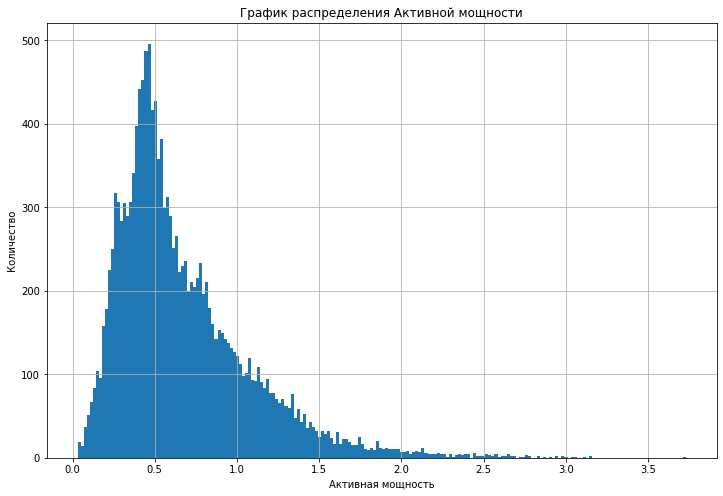

In [10]:
pd.Series(list(data_arc.active_power.unique())).sort_values(ascending=False).plot(kind='hist', figsize=(12,8), grid=True, bins=200)
plt.title('График распределения Активной мощности')
plt.ylabel('Количество')
plt.xlabel('Активная мощность')
plt.show()

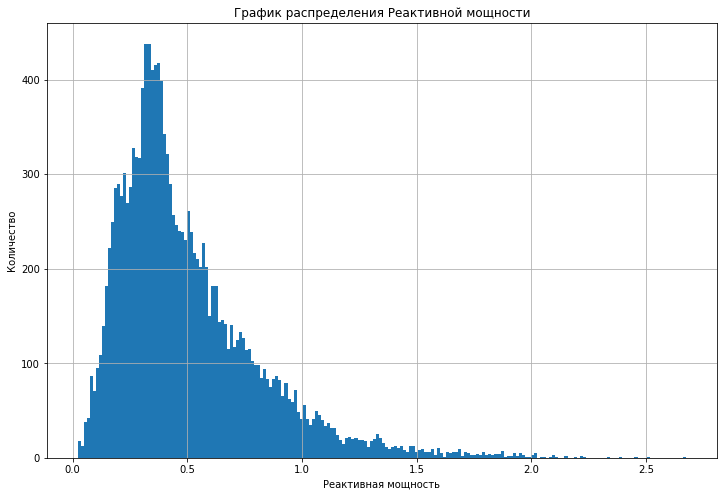

In [11]:
pd.Series(list(data_arc.reactive_power.unique())).sort_values(ascending=False).plot(kind='hist', figsize=(12,8), grid=True, bins=200)
plt.title('График распределения Реактивной мощности')
plt.ylabel('Количество')
plt.xlabel('Реактивная мощность')
plt.show()

По графику активной мощности видим что есть выпадающие, слишком большие значения, но мы их оставим. Они скорее всего получились в следствие того, что метал был остывший и его прриходилось сильно нагревать.

Активная мощность выполняет полезную работу. Реактивная – не выполняет ничего полезного, а только снижает КПД сети, греет провода, грузит генератор. Так что две эти мощности взаимосвязанны и их сумма равна общей использованной мощности для прогрева металла.

### Анализ data_bulk

In [12]:
display(data_bulk.head(10))
# Переименуем названия столбцов 
data_bulk = data_bulk.rename(columns=lambda col: col.replace(" ", "_"))
# Приведем название столбцов к строчному виду
data_bulk.columns = data_bulk.columns.str.lower()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [13]:
display(data_bulk.head(10))

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [14]:
data_bulk.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [16]:
data_bulk = data_bulk.pivot_table(index = 'key')
data_bulk = data_bulk.sort_values(by = 'key')
display(data_bulk.head(10))

,bulk_1,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9
key,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,206.0,NaN,150.0,154.0,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,206.0,NaN,149.0,154.0,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,205.0,NaN,152.0,153.0,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,207.0,NaN,153.0,154.0,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,203.0,NaN,151.0,152.0,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,204.0,NaN,201.0,154.0,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,204.0,NaN,152.0,154.0,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,410.0,NaN,252.0,153.0,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,107.0,NaN,99.0,203.0,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN


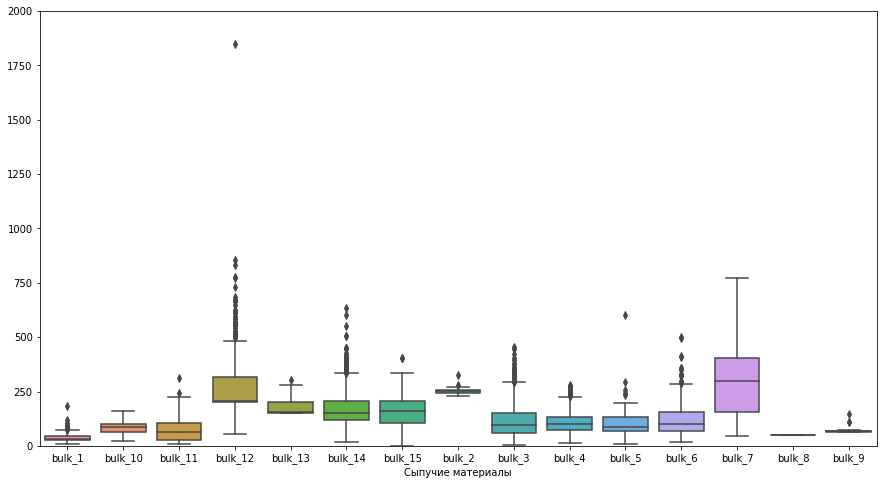

In [17]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(data=data_bulk)
plt.xlabel('Сыпучие материалы')
ax.set_ylim([0, 2000])

plt.show()

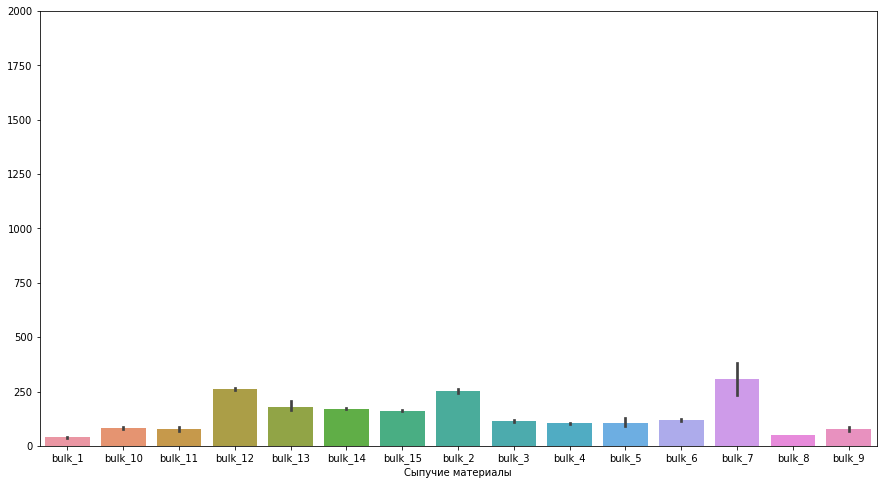

In [18]:
plt.figure(figsize=(15,8))
ax = sns.barplot(data=data_bulk)
plt.xlabel('Сыпучие материалы')
ax.set_ylim([0, 2000])

plt.show()

In [19]:
display(data_bulk_time.head(10))

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


### Анализ data_gas

In [20]:
display(data_gas.head(10))
data_gas.describe()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [21]:
print(data_gas.isna().sum())

key      0
Газ 1    0
dtype: int64


In [22]:
# Переименуем столбец
data_gas.rename(columns = {'Газ 1':'gaz'}, inplace = True )
display(data_gas.head(10))

,key,gaz
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


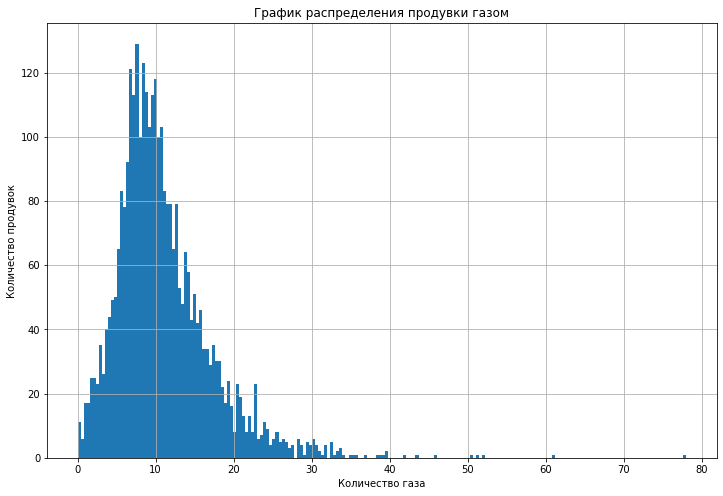

In [23]:
pd.Series(list(data_gas.gaz.unique())).sort_values(ascending=False).plot(kind='hist', figsize=(12,8), grid=True, bins=200)
plt.title('График распределения продувки газом')
plt.ylabel('Количество продувок')
plt.xlabel('Количество газа')
plt.show()

In [24]:
display(data_gas.head(10))

,key,gaz
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


### Анализ data_temp

In [25]:
display(data_temp.head(10))
data_temp.describe()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [26]:
# Переименуем столбец с температурой
data_temp.rename(columns = {'Температура':'temp'}, inplace = True )
display(data_temp.head(10))
data_temp.describe()

,key,Время замера,temp
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


,key,temp
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [27]:
display(data_temp.head(10))

,key,Время замера,temp
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


<AxesSubplot:>

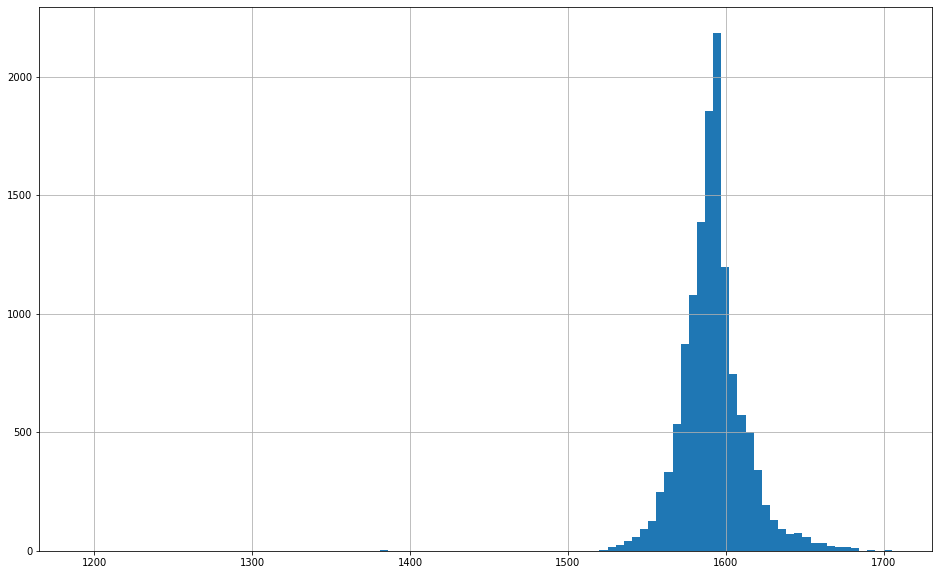

In [28]:
data_temp['temp'].hist(figsize=(16,10),bins=100)

### Анализ data_wire

In [29]:
display(data_wire.head(10))
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [30]:
# Переименуем названия столбцов 
data_wire = data_wire.rename(columns=lambda col: col.replace(" ", "_"))
# Приведем название столбцов к строчному виду
data_wire.columns = data_wire.columns.str.lower()
display(data_wire.head(10))

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
data_wire = data_wire.pivot_table(index = 'key')
data_wire = data_wire.sort_values(by = 'key')

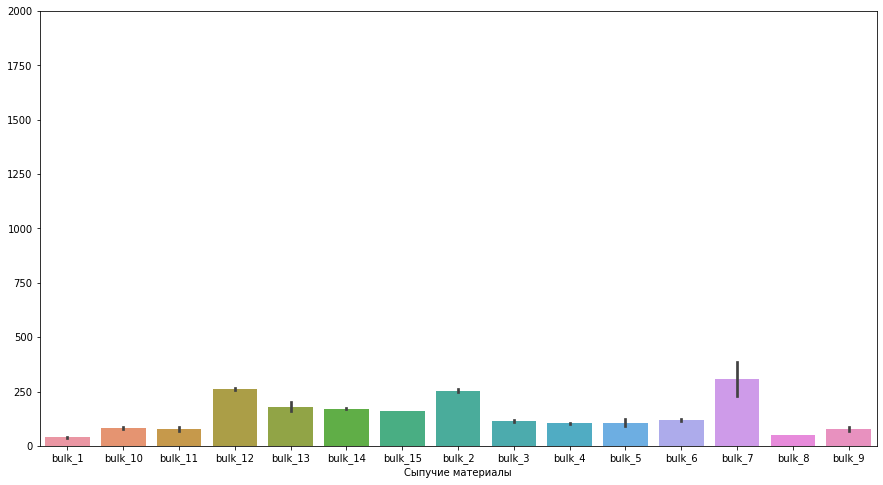

In [32]:
plt.figure(figsize=(15,8))
ax = sns.barplot(data=data_wire)
plt.xlabel('Сыпучие материалы')
ax.set_ylim([0, 2000])

plt.show()

In [33]:
display(data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


План проекта:
1. Знакомство с данными. Загрузим данные, сделаем предобработку данных в таблице. Обьеденим таблицы data_arc, data_bulk, data_gas, data_temp, data_wire. Для нашей задачи таблицы с временем не важны. Выделим целевой признак, это будет промежуточная температура.
2. Обучение моделей. В обучении рассмотрим одну простую модель и один бустинг(LinearRegression, CatBoostRegressor). Выборку поделим на тестовую и тренировочную, это значит,что нужно подбирать гиперпараметры с помощью кросс-валидации (GridSearchCV, RandomizedSearchCV или вручную (cross_val_score)).
3. Анализ моделей. После нахождения лучших гиперпараметров измерим MAE.
4. Тестирование. Рассчитаю финальную метрику лучшей модели на тестовой выборке. Если метрика не дотягивает,надо потюнить гиперпараметры на этапе обучения моделей, заием заново проверить на тестовой.
5. Отчет. Напишем вывод о проделанной работе, какие получились результаты и как к ней пришли. 

# Предобработка данных

In [35]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   temp          13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [36]:
data_temp.head(10)

,key,Время замера,temp
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [37]:
# Cгруппируем по первым и последним значениям
data_temp = data_temp.groupby(by ='key').agg(['first', 'last','count']).reset_index()
data_temp

key         Время замера                               temp          \
                          first                 last count   first    last   
0        1  2019-05-03 11:16:18  2019-05-03 11:30:39     5  1571.0  1613.0   
1        2  2019-05-03 11:37:27  2019-05-03 11:59:12     6  1581.0  1602.0   
2        3  2019-05-03 12:13:17  2019-05-03 12:34:57     5  1596.0  1599.0   
3        4  2019-05-03 12:52:57  2019-05-03 12:59:25     3  1601.0  1625.0   
4        5  2019-05-03 13:23:19  2019-05-03 13:36:01     2  1576.0  1602.0   
...    ...                  ...                  ...   ...     ...     ...   
3211  3237  2019-08-31 22:44:04  2019-08-31 23:05:43     5  1569.0  1569.0   
3212  3238  2019-08-31 23:30:31  2019-08-31 23:43:00     3  1584.0  1584.0   
3213  3239  2019-09-01 01:31:47  2019-09-01 02:24:15     8  1598.0  1598.0   
3214  3240  2019-09-01 02:39:01  2019-09-01 03:35:16     8  1617.0  1617.0   
3215  3241  2019-09-01 04:03:30  2019-09-01 04:38:08     5  1586.0  1586.0   

            
     count  
0        5  
1        6  
2        5  
3        3  
4        2  
...    ...  
3211     1  
3212     1  
3213     1  
3214     1  
3215     1  

[3216 rows x 7 columns]

In [38]:
data_temp.columns = data_temp.columns.droplevel()
data_temp.columns = ['key', 'Время замера 1', 'Время замера 2','count','temp_1','temp_2','count_t']


In [39]:
data_temp['Время замера 1'] = pd.to_datetime(data_temp['Время замера 1'], format='%Y-%m-%d %H:%M:%S')
data_temp['Время замера 2'] = pd.to_datetime(data_temp['Время замера 2'], format='%Y-%m-%d %H:%M:%S')
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             3216 non-null   int64         
 1   Время замера 1  3216 non-null   datetime64[ns]
 2   Время замера 2  3216 non-null   datetime64[ns]
 3   count           3216 non-null   int64         
 4   temp_1          3216 non-null   float64       
 5   temp_2          3216 non-null   float64       
 6   count_t         3216 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(3)
memory usage: 176.0 KB


In [40]:
#data_temp[(data_temp['Время замера 1'])==(data_temp['Время замера 2'])]
data_temp[data_temp['Время замера 1'] == data_temp['Время замера 2']]

,key,Время замера 1,Время замера 2,count,temp_1,temp_2,count_t
192,195,2019-05-10 14:10:23,2019-05-10 14:10:23,1,1583.0,1583.0,1
276,279,2019-05-13 23:07:28,2019-05-13 23:07:28,1,1603.0,1603.0,1


In [41]:
data_temp = data_temp[data_temp['Время замера 1'] != data_temp['Время замера 2']]

In [42]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3215
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             3214 non-null   int64         
 1   Время замера 1  3214 non-null   datetime64[ns]
 2   Время замера 2  3214 non-null   datetime64[ns]
 3   count           3214 non-null   int64         
 4   temp_1          3214 non-null   float64       
 5   temp_2          3214 non-null   float64       
 6   count_t         3214 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(3)
memory usage: 200.9 KB


In [43]:
data_temp = data_temp[data_temp['temp_1']>1500]
data_temp = data_temp[data_temp['temp_2']>1500]

In [44]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3209 entries, 0 to 3215
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             3209 non-null   int64         
 1   Время замера 1  3209 non-null   datetime64[ns]
 2   Время замера 2  3209 non-null   datetime64[ns]
 3   count           3209 non-null   int64         
 4   temp_1          3209 non-null   float64       
 5   temp_2          3209 non-null   float64       
 6   count_t         3209 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(3)
memory usage: 200.6 KB


In [45]:
data_temp[data_temp['count_t']==1]

,key,Время замера 1,Время замера 2,count,temp_1,temp_2,count_t
2477,2500,2019-08-06 03:11:31,2019-08-06 03:28:21,4,1539.0,1539.0,1
2478,2501,2019-08-06 03:44:42,2019-08-06 04:31:14,5,1587.0,1587.0,1
2479,2502,2019-08-06 04:45:26,2019-08-06 05:12:20,7,1583.0,1583.0,1
2480,2503,2019-08-06 05:32:06,2019-08-06 06:07:35,4,1603.0,1603.0,1
2481,2504,2019-08-06 06:35:39,2019-08-06 07:04:16,3,1583.0,1583.0,1
...,...,...,...,...,...,...,...
3211,3237,2019-08-31 22:44:04,2019-08-31 23:05:43,5,1569.0,1569.0,1
3212,3238,2019-08-31 23:30:31,2019-08-31 23:43:00,3,1584.0,1584.0,1
3213,3239,2019-09-01 01:31:47,2019-09-01 02:24:15,8,1598.0,1598.0,1
3214,3240,2019-09-01 02:39:01,2019-09-01 03:35:16,8,1617.0,1617.0,1


In [46]:
data_temp = data_temp[data_temp['count_t']>1]

In [47]:
data_temp[data_temp['count_t']==1]

,key,Время замера 1,Время замера 2,count,temp_1,temp_2,count_t


In [48]:
data_temp = data_temp[['key','temp_1','temp_2']]

In [49]:
display(data_temp.head())

,key,temp_1,temp_2
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


In [50]:
data_temp.describe()

,key,temp_1,temp_2
count,2471.000000,2471.000000,2471.000000
mean,1250.484015,1589.012950,1595.339943
std,720.109488,25.004369,16.035215
min,1.000000,1519.000000,1541.000000
25%,628.500000,1572.000000,1587.000000
50%,1252.000000,1588.000000,1593.000000
75%,1872.500000,1605.000000,1599.000000
max,2499.000000,1679.000000,1700.000000


In [51]:
data_temp.isnull().sum()

key       0
temp_1    0
temp_2    0
dtype: int64

In [52]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 0 to 2476
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     2471 non-null   int64  
 1   temp_1  2471 non-null   float64
 2   temp_2  2471 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 77.2 KB


In [53]:
display(data_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


In [54]:
data_arc = data_arc.groupby(by = 'key', as_index = False).agg(['sum', 'mean']).reset_index()
display(data_arc)

key active_power           reactive_power          
                    sum      mean            sum      mean
0        1     4.878147  0.975629       3.183241  0.636648
1        2     3.052598  0.763150       1.998112  0.499528
2        3     2.525882  0.505176       1.599076  0.319815
3        4     3.209250  0.802313       2.060298  0.515074
4        5     3.347173  0.836793       2.252643  0.563161
...    ...          ...       ...            ...       ...
3209  3237     3.932467  0.786493       2.828459  0.565692
3210  3238     2.106529  0.702176       1.681182  0.560394
3211  3239     4.666754  0.583344       3.111617  0.388952
3212  3240     2.984083  0.596817       2.483267  0.496653
3213  3241     2.471447  0.494289       1.696199  0.339240

[3214 rows x 5 columns]

In [55]:
data_arc.columns = data_arc.columns.droplevel()
data_arc.columns = ['key', 'active_sum', 'active_mean','reactive_sum','reactive_mean']

data_arc

,key,active_sum,active_mean,reactive_sum,reactive_mean
0,1,4.878147,0.975629,3.183241,0.636648
1,2,3.052598,0.763150,1.998112,0.499528
2,3,2.525882,0.505176,1.599076,0.319815
3,4,3.209250,0.802313,2.060298,0.515074
4,5,3.347173,0.836793,2.252643,0.563161
...,...,...,...,...,...
3209,3237,3.932467,0.786493,2.828459,0.565692
3210,3238,2.106529,0.702176,1.681182,0.560394
3211,3239,4.666754,0.583344,3.111617,0.388952
3212,3240,2.984083,0.596817,2.483267,0.496653


In [56]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            3214 non-null   int64  
 1   active_sum     3214 non-null   float64
 2   active_mean    3214 non-null   float64
 3   reactive_sum   3214 non-null   float64
 4   reactive_mean  3214 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [57]:
# Заполним пропуски 0 в wire и bulk
data_wire = data_wire.fillna('0')
data_bulk = data_bulk.fillna('0')

In [58]:
display(data_wire.head())

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,
1,60.059998,0,0,0,0,0,0,0,0
2,96.052315,0,0,0,0,0,0,0,0
3,91.160157,0,0,0,0,0,0,0,0
4,89.063515,0,0,0,0,0,0,0,0
5,89.238236,9.11456,0,0,0,0,0,0,0


In [59]:
data_wire = data_wire.rename_axis('key').reset_index()

In [60]:
display(data_wire.head())

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0,0,0,0,0,0,0,0
1,2,96.052315,0,0,0,0,0,0,0,0
2,3,91.160157,0,0,0,0,0,0,0,0
3,4,89.063515,0,0,0,0,0,0,0,0
4,5,89.238236,9.11456,0,0,0,0,0,0,0


In [61]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   wire_1  3081 non-null   object
 2   wire_2  3081 non-null   object
 3   wire_3  3081 non-null   object
 4   wire_4  3081 non-null   object
 5   wire_5  3081 non-null   object
 6   wire_6  3081 non-null   object
 7   wire_7  3081 non-null   object
 8   wire_8  3081 non-null   object
 9   wire_9  3081 non-null   object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [62]:
display(data_bulk.head())

,bulk_1,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9
key,,,,,,,,,,,,,,,
1,0,0,0,206.0,0,150.0,154.0,0,0,43.0,0,0,0,0,0
2,0,0,0,206.0,0,149.0,154.0,0,0,73.0,0,0,0,0,0
3,0,0,0,205.0,0,152.0,153.0,0,0,34.0,0,0,0,0,0
4,0,0,0,207.0,0,153.0,154.0,0,0,81.0,0,0,0,0,0
5,0,0,0,203.0,0,151.0,152.0,0,0,78.0,0,0,0,0,0


In [63]:
data_bulk = data_bulk.rename_axis('key').reset_index()

In [64]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk_1   3129 non-null   object
 2   bulk_10  3129 non-null   object
 3   bulk_11  3129 non-null   object
 4   bulk_12  3129 non-null   object
 5   bulk_13  3129 non-null   object
 6   bulk_14  3129 non-null   object
 7   bulk_15  3129 non-null   object
 8   bulk_2   3129 non-null   object
 9   bulk_3   3129 non-null   object
 10  bulk_4   3129 non-null   object
 11  bulk_5   3129 non-null   object
 12  bulk_6   3129 non-null   object
 13  bulk_7   3129 non-null   object
 14  bulk_8   3129 non-null   object
 15  bulk_9   3129 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [65]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gaz     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [66]:
data_new = (data_temp.merge(data_arc, on='key', how='left').merge(data_gas, on='key').merge(data_wire,
                            on='key').merge(data_bulk, on='key'))
display(data_new)

,key,temp_1,temp_2,active_sum,active_mean,reactive_sum,reactive_mean,gaz,wire_1,wire_2,...,bulk_14,bulk_15,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9
0,1,1571.0,1613.0,4.878147,0.975629,3.183241,0.636648,29.749986,60.059998,0,...,150.0,154.0,0,0,43.0,0,0,0,0,0
1,2,1581.0,1602.0,3.052598,0.763150,1.998112,0.499528,12.555561,96.052315,0,...,149.0,154.0,0,0,73.0,0,0,0,0,0
2,3,1596.0,1599.0,2.525882,0.505176,1.599076,0.319815,28.554793,91.160157,0,...,152.0,153.0,0,0,34.0,0,0,0,0,0
3,4,1601.0,1625.0,3.209250,0.802313,2.060298,0.515074,18.841219,89.063515,0,...,153.0,154.0,0,0,81.0,0,0,0,0,0
4,5,1576.0,1602.0,3.347173,0.836793,2.252643,0.563161,5.413692,89.238236,9.11456,...,151.0,152.0,0,0,78.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,2495,1570.0,1591.0,3.210690,0.802673,2.360777,0.590194,7.125735,89.150879,0,...,129.0,223.0,0,21.0,0,0,0,0,0,0
2321,2496,1554.0,1591.0,4.203064,0.700511,2.810185,0.468364,9.412616,114.179527,0,...,129.0,226.0,0,0,63.0,0,0,0,0,0
2322,2497,1571.0,1589.0,2.212379,0.737460,1.851269,0.617090,6.271699,94.086723,9.048,...,124.0,226.0,0,0,85.0,0,0,0,0,0
2323,2498,1591.0,1594.0,3.408725,0.681745,2.355428,0.471086,14.953657,118.110717,0,...,129.0,207.0,0,90.0,0,0,0,0,0,0


In [68]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            2325 non-null   int64  
 1   temp_1         2325 non-null   float64
 2   temp_2         2325 non-null   float64
 3   active_sum     2325 non-null   float64
 4   active_mean    2325 non-null   float64
 5   reactive_sum   2325 non-null   float64
 6   reactive_mean  2325 non-null   float64
 7   gaz            2325 non-null   float64
 8   wire_1         2325 non-null   object 
 9   wire_2         2325 non-null   object 
 10  wire_3         2325 non-null   object 
 11  wire_4         2325 non-null   object 
 12  wire_5         2325 non-null   object 
 13  wire_6         2325 non-null   object 
 14  wire_7         2325 non-null   object 
 15  wire_8         2325 non-null   object 
 16  wire_9         2325 non-null   object 
 17  bulk_1         2325 non-null   object 
 18  bulk_10 

In [69]:
display(data_new)

,key,temp_1,temp_2,active_sum,active_mean,reactive_sum,reactive_mean,gaz,wire_1,wire_2,...,bulk_14,bulk_15,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9
0,1,1571.0,1613.0,4.878147,0.975629,3.183241,0.636648,29.749986,60.059998,0,...,150.0,154.0,0,0,43.0,0,0,0,0,0
1,2,1581.0,1602.0,3.052598,0.763150,1.998112,0.499528,12.555561,96.052315,0,...,149.0,154.0,0,0,73.0,0,0,0,0,0
2,3,1596.0,1599.0,2.525882,0.505176,1.599076,0.319815,28.554793,91.160157,0,...,152.0,153.0,0,0,34.0,0,0,0,0,0
3,4,1601.0,1625.0,3.209250,0.802313,2.060298,0.515074,18.841219,89.063515,0,...,153.0,154.0,0,0,81.0,0,0,0,0,0
4,5,1576.0,1602.0,3.347173,0.836793,2.252643,0.563161,5.413692,89.238236,9.11456,...,151.0,152.0,0,0,78.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,2495,1570.0,1591.0,3.210690,0.802673,2.360777,0.590194,7.125735,89.150879,0,...,129.0,223.0,0,21.0,0,0,0,0,0,0
2321,2496,1554.0,1591.0,4.203064,0.700511,2.810185,0.468364,9.412616,114.179527,0,...,129.0,226.0,0,0,63.0,0,0,0,0,0
2322,2497,1571.0,1589.0,2.212379,0.737460,1.851269,0.617090,6.271699,94.086723,9.048,...,124.0,226.0,0,0,85.0,0,0,0,0,0
2323,2498,1591.0,1594.0,3.408725,0.681745,2.355428,0.471086,14.953657,118.110717,0,...,129.0,207.0,0,90.0,0,0,0,0,0,0


In [70]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            2325 non-null   int64  
 1   temp_1         2325 non-null   float64
 2   temp_2         2325 non-null   float64
 3   active_sum     2325 non-null   float64
 4   active_mean    2325 non-null   float64
 5   reactive_sum   2325 non-null   float64
 6   reactive_mean  2325 non-null   float64
 7   gaz            2325 non-null   float64
 8   wire_1         2325 non-null   object 
 9   wire_2         2325 non-null   object 
 10  wire_3         2325 non-null   object 
 11  wire_4         2325 non-null   object 
 12  wire_5         2325 non-null   object 
 13  wire_6         2325 non-null   object 
 14  wire_7         2325 non-null   object 
 15  wire_8         2325 non-null   object 
 16  wire_9         2325 non-null   object 
 17  bulk_1         2325 non-null   object 
 18  bulk_10 

In [71]:
data_new.describe()

,key,temp_1,temp_2,active_sum,active_mean,reactive_sum,reactive_mean,gaz
count,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000
mean,1251.512258,1587.365161,1593.366022,3.153796,0.669305,2.352247,0.499474,11.378942
std,715.099053,23.623144,11.209581,1.425507,0.196991,1.081840,0.147426,6.395632
min,1.000000,1519.000000,1541.000000,0.186226,0.186226,0.158247,0.130062,0.008399
25%,629.000000,1571.000000,1587.000000,2.173854,0.526458,1.627106,0.392566,7.282948
50%,1255.000000,1587.000000,1593.000000,3.029259,0.644934,2.235299,0.487958,10.100950
75%,1868.000000,1603.000000,1598.000000,3.920864,0.792080,2.915890,0.592560,14.217691
max,2499.000000,1660.000000,1653.000000,17.496497,1.421416,12.587990,1.134983,77.995040


In [72]:
# Найдем ключи где температура меньше 1500
data_new[data_new['temp_1']<=1500]


,key,temp_1,temp_2,active_sum,active_mean,reactive_sum,reactive_mean,gaz,wire_1,wire_2,...,bulk_14,bulk_15,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9


In [73]:
# Найдем ключи где температура меньше 1500
data_new[data_new['temp_2']<=1500]

,key,temp_1,temp_2,active_sum,active_mean,reactive_sum,reactive_mean,gaz,wire_1,wire_2,...,bulk_14,bulk_15,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9


In [74]:
data_new.isnull().sum()

key              0
temp_1           0
temp_2           0
active_sum       0
active_mean      0
reactive_sum     0
reactive_mean    0
gaz              0
wire_1           0
wire_2           0
wire_3           0
wire_4           0
wire_5           0
wire_6           0
wire_7           0
wire_8           0
wire_9           0
bulk_1           0
bulk_10          0
bulk_11          0
bulk_12          0
bulk_13          0
bulk_14          0
bulk_15          0
bulk_2           0
bulk_3           0
bulk_4           0
bulk_5           0
bulk_6           0
bulk_7           0
bulk_8           0
bulk_9           0
dtype: int64

In [75]:
data_new = data_new.astype (float)

In [76]:
print(data_new.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            2325 non-null   float64
 1   temp_1         2325 non-null   float64
 2   temp_2         2325 non-null   float64
 3   active_sum     2325 non-null   float64
 4   active_mean    2325 non-null   float64
 5   reactive_sum   2325 non-null   float64
 6   reactive_mean  2325 non-null   float64
 7   gaz            2325 non-null   float64
 8   wire_1         2325 non-null   float64
 9   wire_2         2325 non-null   float64
 10  wire_3         2325 non-null   float64
 11  wire_4         2325 non-null   float64
 12  wire_5         2325 non-null   float64
 13  wire_6         2325 non-null   float64
 14  wire_7         2325 non-null   float64
 15  wire_8         2325 non-null   float64
 16  wire_9         2325 non-null   float64
 17  bulk_1         2325 non-null   float64
 18  bulk_10 

# Обучение моделей

In [77]:
# Разделим данные на целевой признак и основные
features = data_new.drop(['temp_2','key'], axis=1)  # извлекаем признаки 
target = data_new['temp_2'] # извлекаем целевой признак

In [78]:
# Разделим на выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=131222) # разобьем на обучающую и тестовые выборки

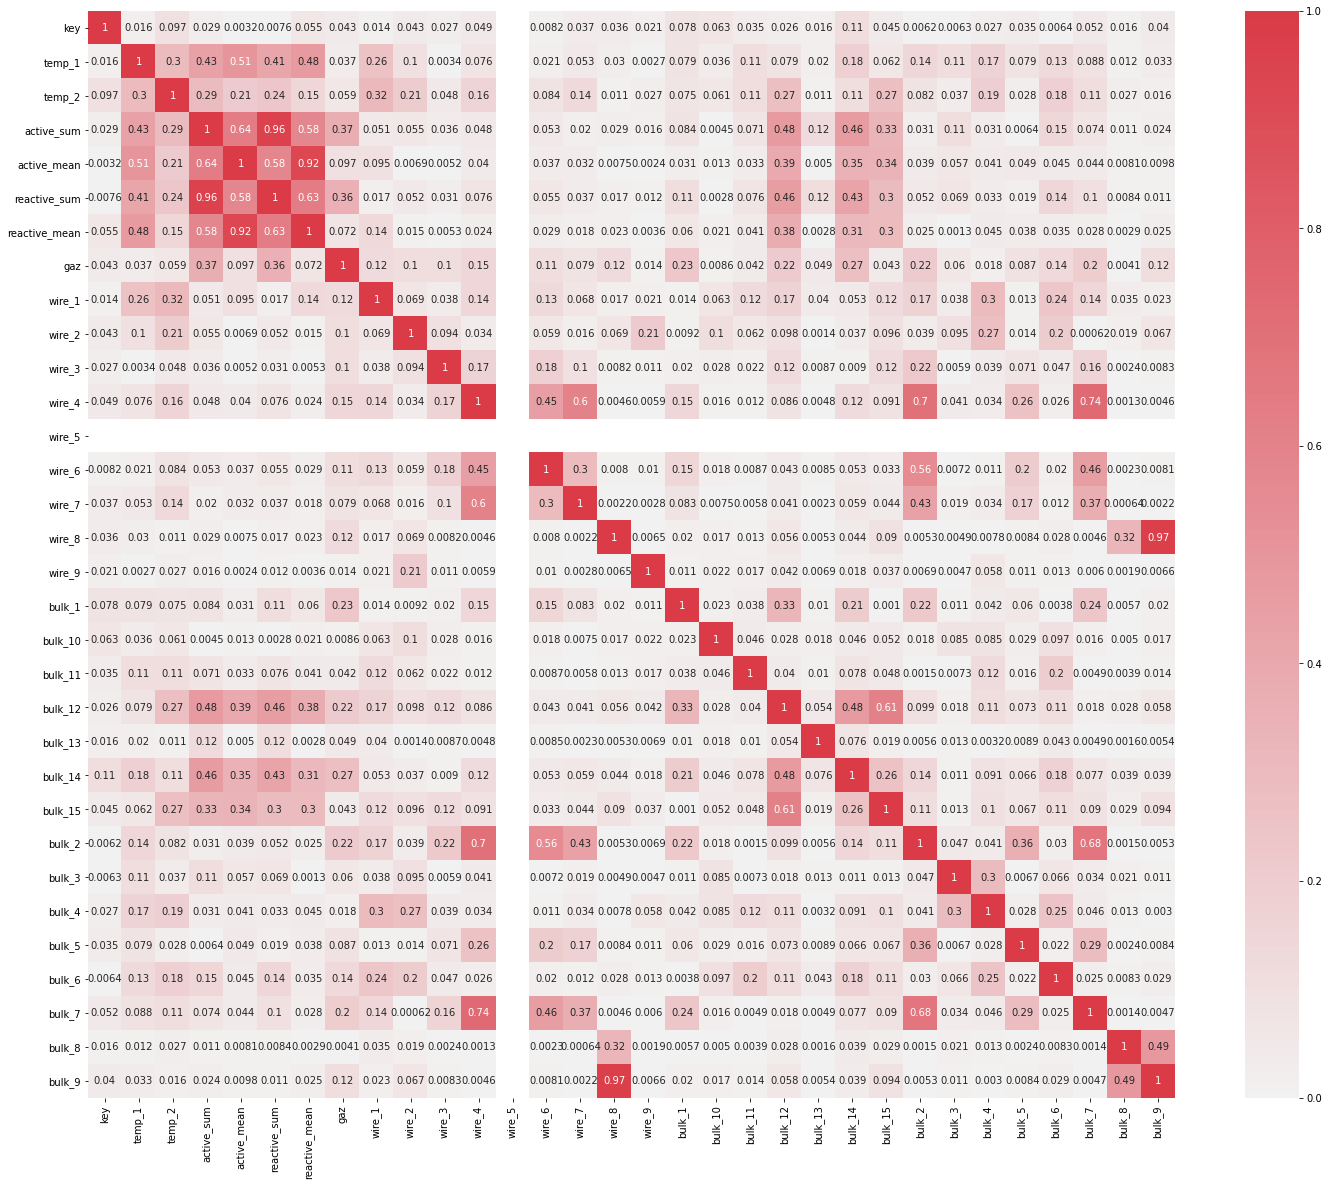

In [79]:
corr = abs(data_new.corr())

f, ax = plt.subplots(figsize=(25, 20))

font = {'size': 10}
plt.rc('font', **font)

cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax = sns.heatmap(
    corr,          
    cmap=cmap,     
    annot=True,    
    vmax=1,      
    vmin=0,      
    center=0,      
    square=True,   
    linewidths=0, 
    xticklabels=True, yticklabels=True
)

Столбец wire_5, пустой его можно удалить. Также в reactive_sum и reactive_mean большая корреляция их тоже удаляем. Большая корреляция между wire_8 и bulk_9, удаляем wire_8.

In [80]:
data_new = data_new.drop(['wire_5','reactive_sum','reactive_mean','wire_8'], axis = 1)

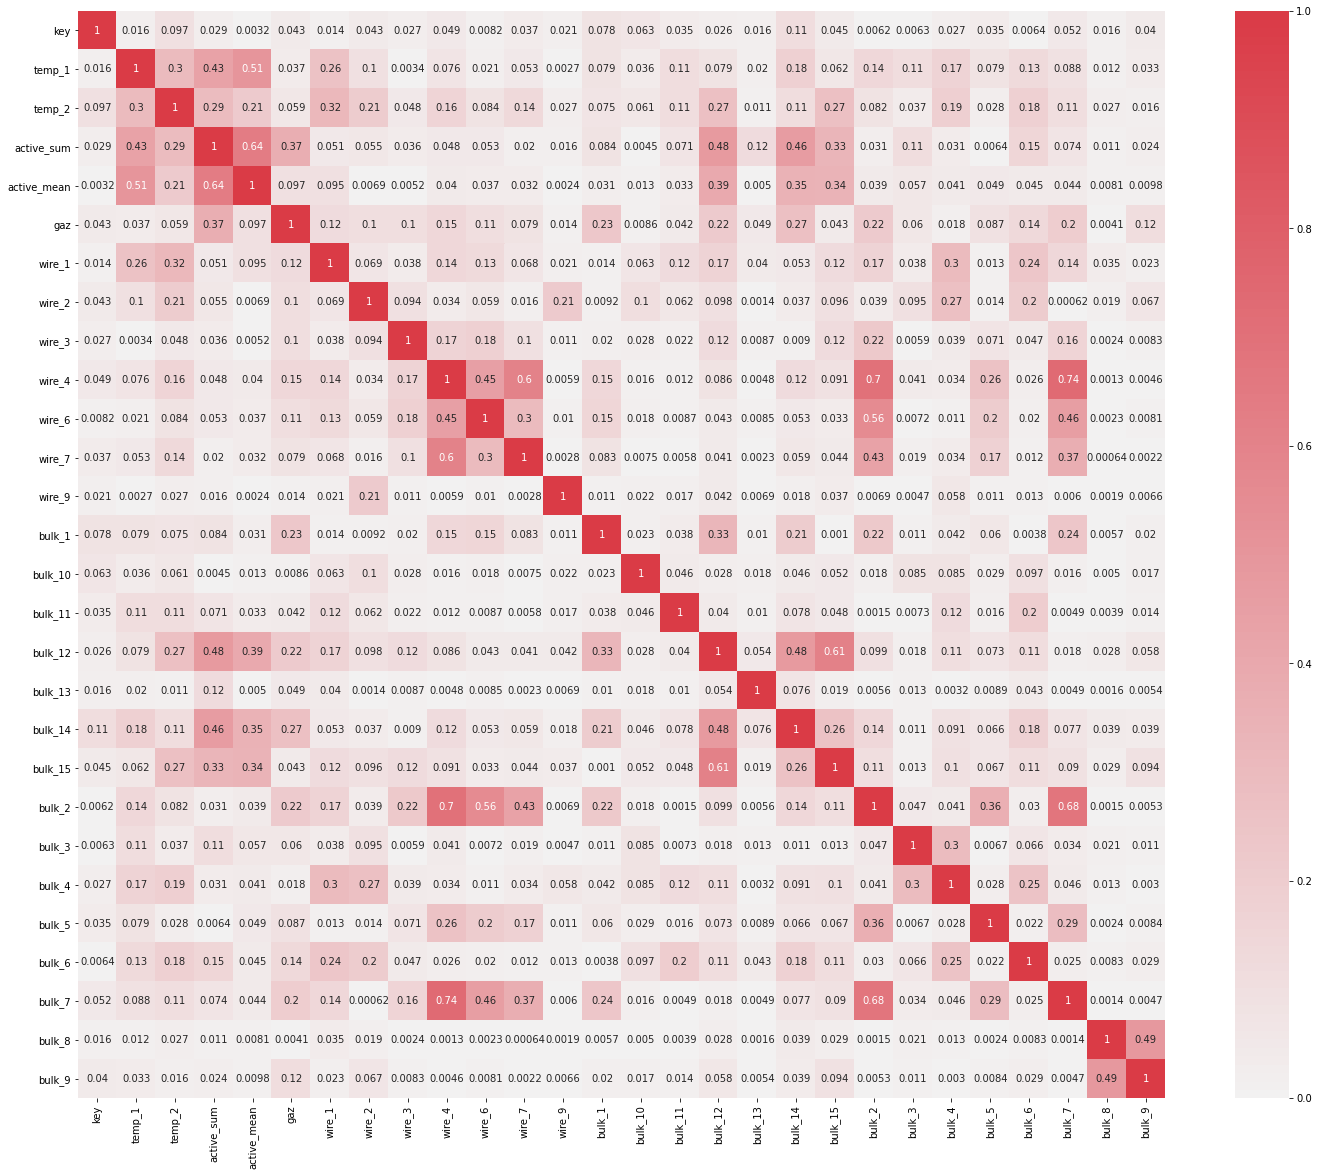

In [81]:
corr = abs(data_new.corr())

f, ax = plt.subplots(figsize=(25, 20))

font = {'size': 10}
plt.rc('font', **font)

cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax = sns.heatmap(
    corr,          
    cmap=cmap,     
    annot=True,    
    vmax=1,       
    vmin=0,      
    center=0,      
    square=True,   
    linewidths=0, 
    xticklabels=True, yticklabels=True
)

In [82]:
# Разделим данные на целевой признак и основные
features_lr = data_new.drop(['temp_2'], axis=1)  # извлекаем признаки

In [83]:
# Разделим на выборки
features_train_lr, features_test_lr, target_train_lr, target_test_lr = train_test_split(
    features_lr, target, test_size=0.25, random_state=131222) # разобьем на обучающую и тестовые выборки

In [84]:
# С помощью метода StandardScaler применим масштабирование к нашим данным

scaler=StandardScaler()
scaler.fit(features_train_lr)

features_train_lr=scaler.transform(features_train_lr)
features_test_lr=scaler.transform(features_test_lr)

print(features_train_lr.shape)
print(features_test_lr.shape)

(1743, 27)
(582, 27)


### LinearRegression

In [85]:
model_lr = LinearRegression(normalize = True)
model_lr.fit(features_train_lr, target_train_lr)

MAE_lr = (cross_val_score(model_lr, features_train_lr, target_train_lr,scoring='neg_mean_absolute_error', cv=5).mean()*-1)
print(cross_val_score(model_lr, features_train_lr, target_train_lr,scoring='neg_mean_absolute_error', cv=5).mean()*-1)
print(MAE_lr)

12.953870041792822
12.953870041792822


### RandomForestRegressor

In [86]:
model_forest=RandomForestRegressor(random_state=131222, n_estimators=100)
model_forest.fit(features_train, target_train)
prediction_forest=model_forest.predict(features_train)
param_grid = {'n_estimators': range (10, 51, 10),
              'max_depth': range (4,8)}

clf = RandomForestRegressor()

grid = GridSearchCV(clf, param_grid, scoring='neg_mean_absolute_error', cv=5)
grid.fit(features_train, target_train)
MAE_rf = grid.best_score_
MAE_rf=MAE_rf*-1
print(MAE_rf)

6.050552410550692


### CatBoostRegressor

In [87]:
# Обучим на CatBoostRegressor
model_cat = CatBoostRegressor(n_estimators=1000, random_state=131222, verbose=100)
model_cat.fit(features_train, target_train, eval_set=(features_train,target_train))

params_cat = {
    'learning_rate': [0.1,0.3,0.5],
    'depth': [4,10],
    }

grid_cat = GridSearchCV(estimator=model_cat,param_grid = params_cat, scoring='neg_mean_absolute_error', cv=5)
grid_cat.fit(features_train, target_train)
MAE_cat = grid_cat.best_score_
print(MAE_cat*-1)

Learning rate set to 0.055562
0:	learn: 11.1175151	test: 11.1175151	best: 11.1175151 (0)	total: 51.7ms	remaining: 51.7s
100:	learn: 6.9972675	test: 6.9972675	best: 6.9972675 (100)	total: 438ms	remaining: 3.9s
200:	learn: 6.2070457	test: 6.2070457	best: 6.2070457 (200)	total: 799ms	remaining: 3.18s
300:	learn: 5.5115190	test: 5.5115190	best: 5.5115190 (300)	total: 1.17s	remaining: 2.73s
400:	learn: 4.8966097	test: 4.8966097	best: 4.8966097 (400)	total: 1.53s	remaining: 2.29s
500:	learn: 4.4244462	test: 4.4244462	best: 4.4244462 (500)	total: 1.87s	remaining: 1.86s
600:	learn: 4.0532540	test: 4.0532540	best: 4.0532540 (600)	total: 2.24s	remaining: 1.48s
700:	learn: 3.7463502	test: 3.7463502	best: 3.7463502 (700)	total: 2.61s	remaining: 1.11s
800:	learn: 3.4412237	test: 3.4412237	best: 3.4412237 (800)	total: 3s	remaining: 744ms
900:	learn: 3.1624438	test: 3.1624438	best: 3.1624438 (900)	total: 3.4s	remaining: 374ms
999:	learn: 2.9520826	test: 2.9520826	best: 2.9520826 (999)	total: 3.78s	re

In [88]:
MAE_cat = MAE_cat*-1
print(MAE_cat)

5.851580833901602


# Анализ моделей¶

In [89]:
column=['MAE модели']

general_tabl = pd.DataFrame(index=['RMSE модели'], columns=['LinearRegression','RandomForestRegressor','CatBoostRegressor'])
general_tabl['LinearRegression'] = MAE_lr
general_tabl['RandomForestRegressor'] = MAE_rf
general_tabl['CatBoostRegressor'] = MAE_cat

print(general_tabl)

             LinearRegression  RandomForestRegressor  CatBoostRegressor
RMSE модели          12.95387               6.050552           5.851581


Самую лучшую модель мы получили на CatBoost

In [90]:
predict_cat_t=grid_cat.predict(features_test)
mae_cat_t = mean_absolute_error(target_test, predict_cat_t)
print(mae_cat_t)

6.198210481019989


# ИТОГ
1. Знакомство с данными:
 
 - Импортировали необходимые библиотеки;
 
 - Загрузили датасеты;
 
 - Провели первичный осмотр каждого датасета;
 
 - Определяли пропуски и дубликаты;
 
 - Проверили данные на аномальность;
 
 - Сделали предобработку данных, удалили данные в которых были с аномалии такие как температура ниже 1500 градусов, для некоторых ключей отсутсвовали вторичные замеры температуры, в реактивной мощности были данные ниже 0;
 
 - Выделели целевой признак, это конечная температура.
 

2. Обучение моделей:

 - Полученную итогувую таблицу поделили на тренировочную-75% и тренировочную-25%, взяли random_state=131222. 

 - Выбрали 3 модели на обучение(LinearRegression, RandomForestRegressor, CatBoostRegressor);
 
 - Для LinearRegression проверили данные на мультиколлинеарность и удалили лишние строки, также отмаштабировали данные. Сделали отдельный  features_lr с признаками.
 
 - Для остальных 2х моделей данные оставили в таком виде в каком они были в итоговой таблице.
 
 - Для LinearRegression мы использовали ручную кросс-валидацию, для остальных моделей GridSearchCV.
 

3. Анализ моделей:

 - После нахождения лучших гиперпараметров для каждой модели измерили MAE.
 
 - Лучший показатель у CatBoostRegressor 5.85
 

4. Тестирование:

 - На тестовых данных вычислили MAE для CatBoostRegressor. Результат равен 6.19. Что вполне вписывается в нужную нам границу целевой метрики.